Running Enhanced Fairness Augmentation Analysis...


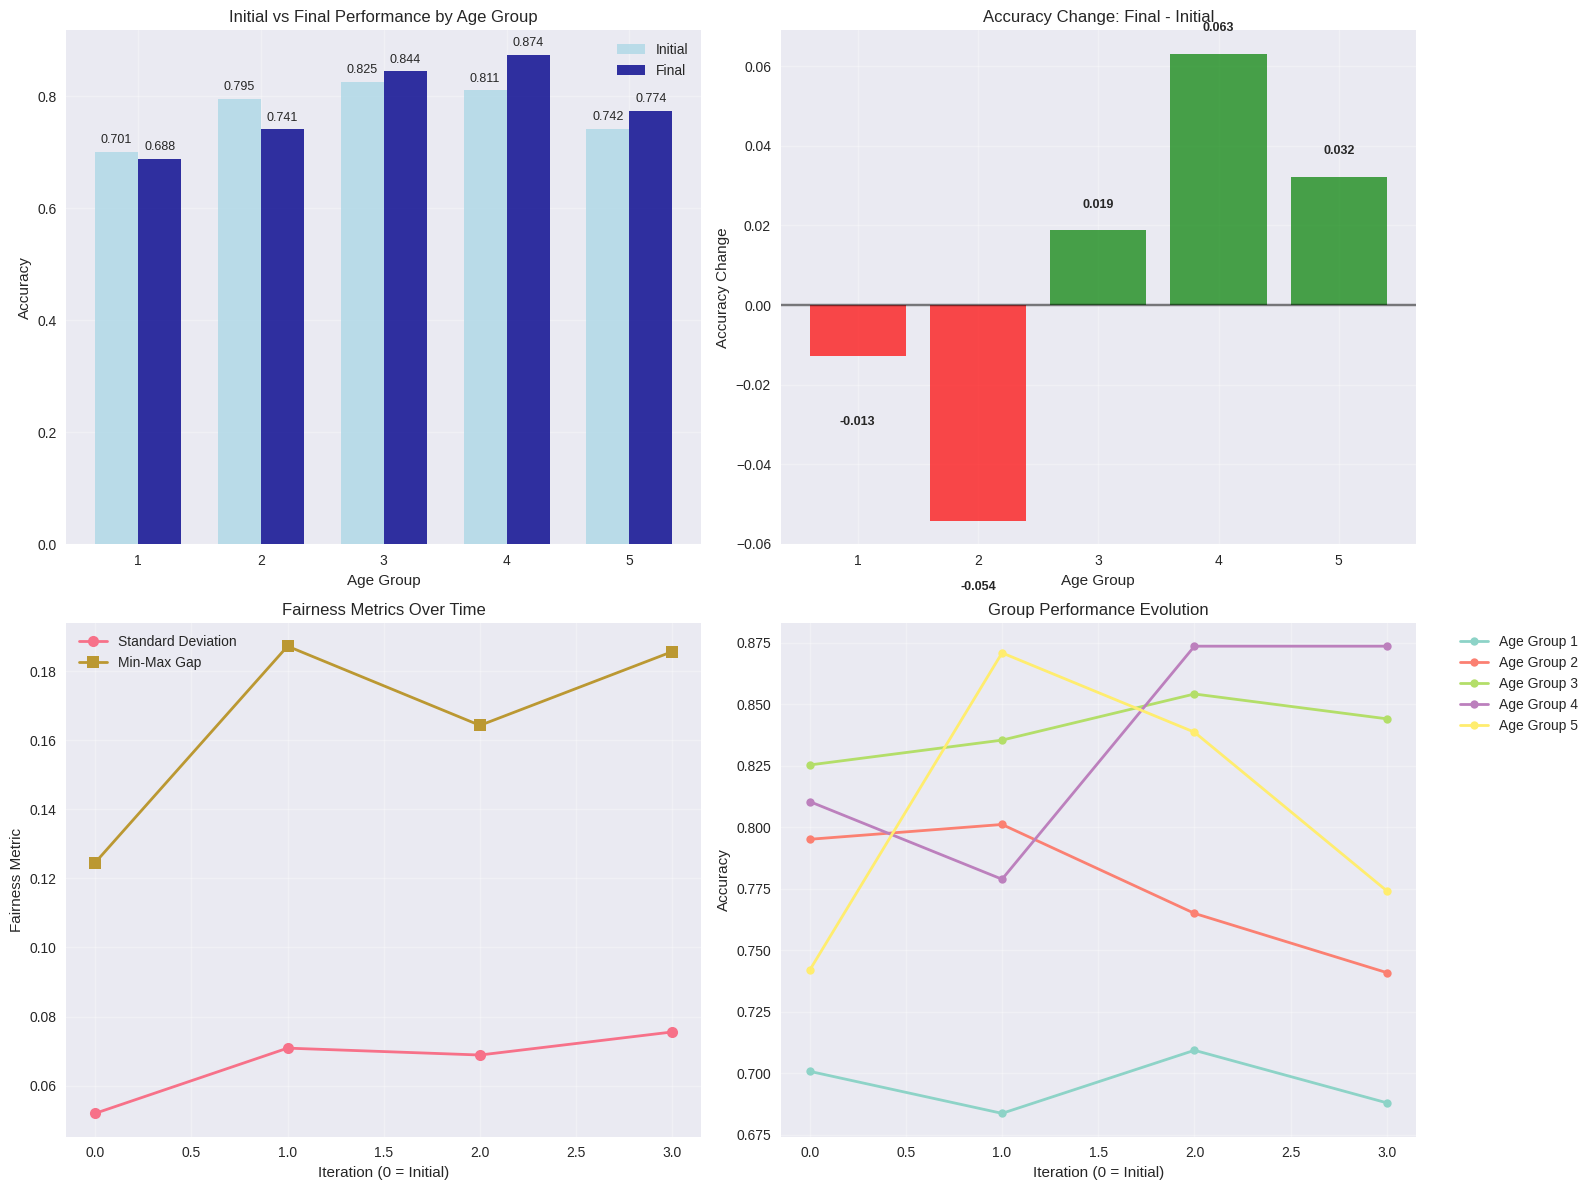

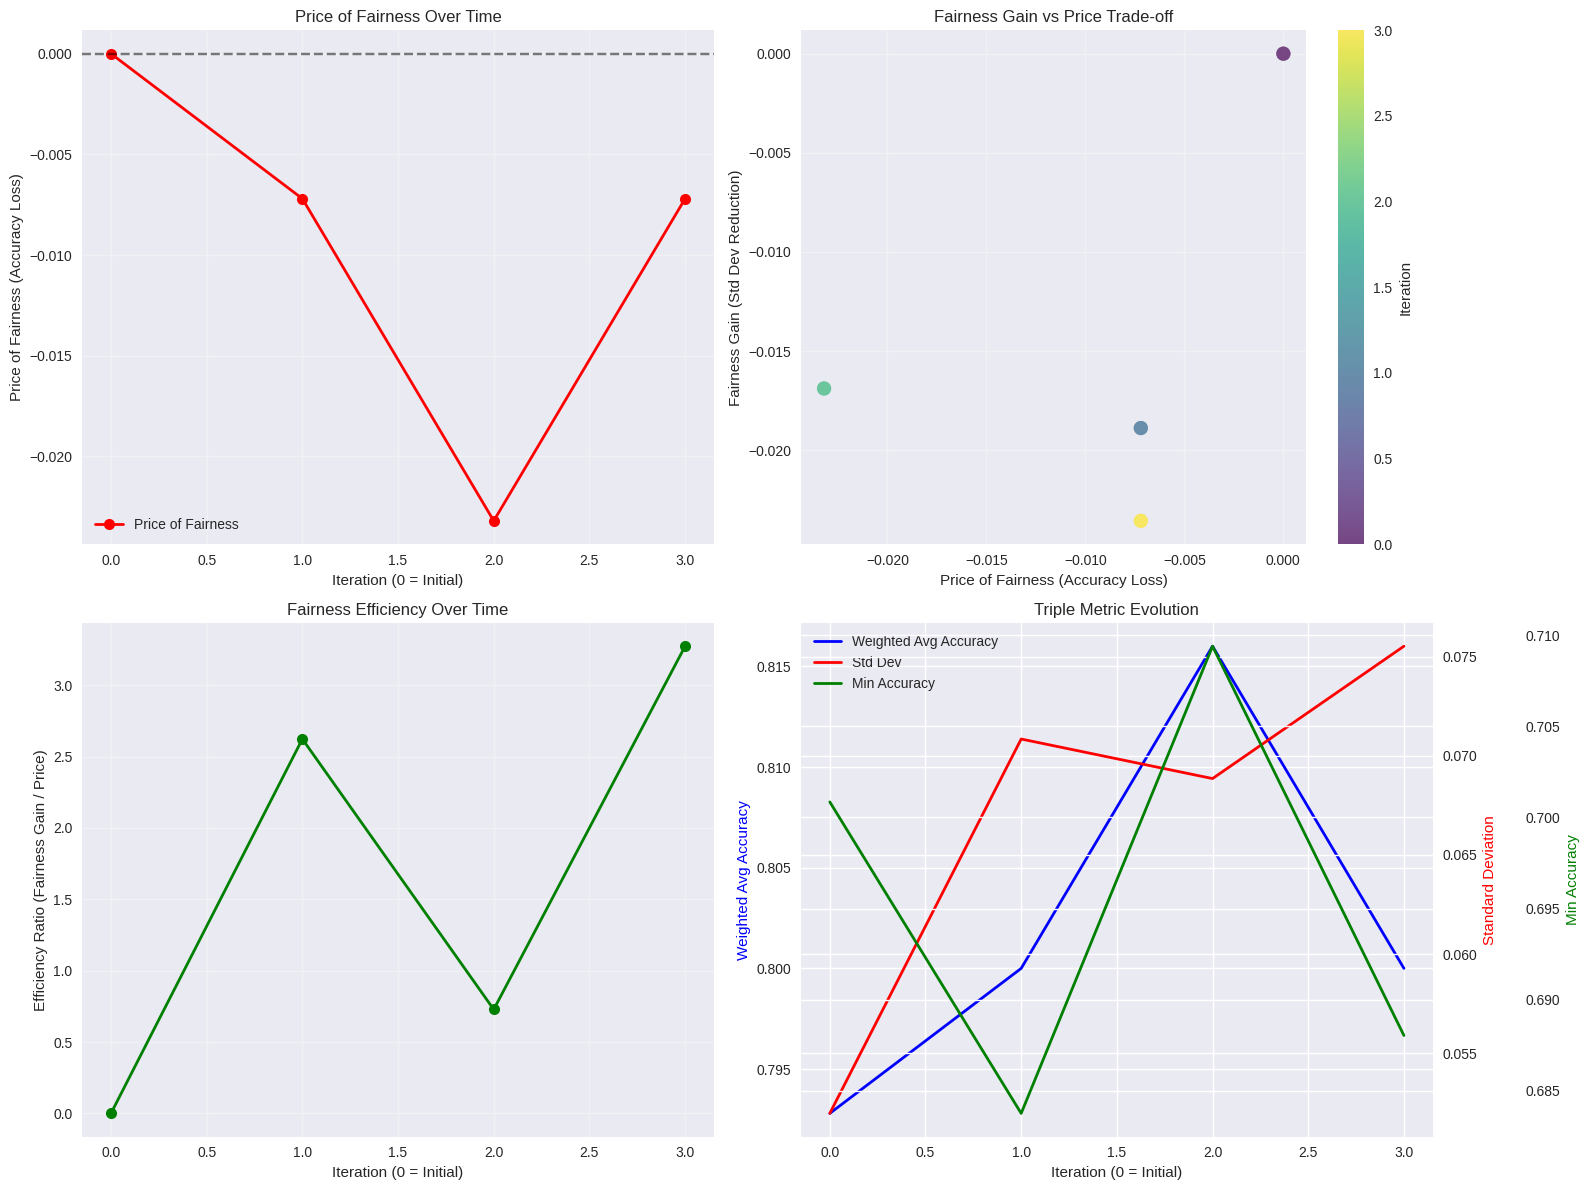

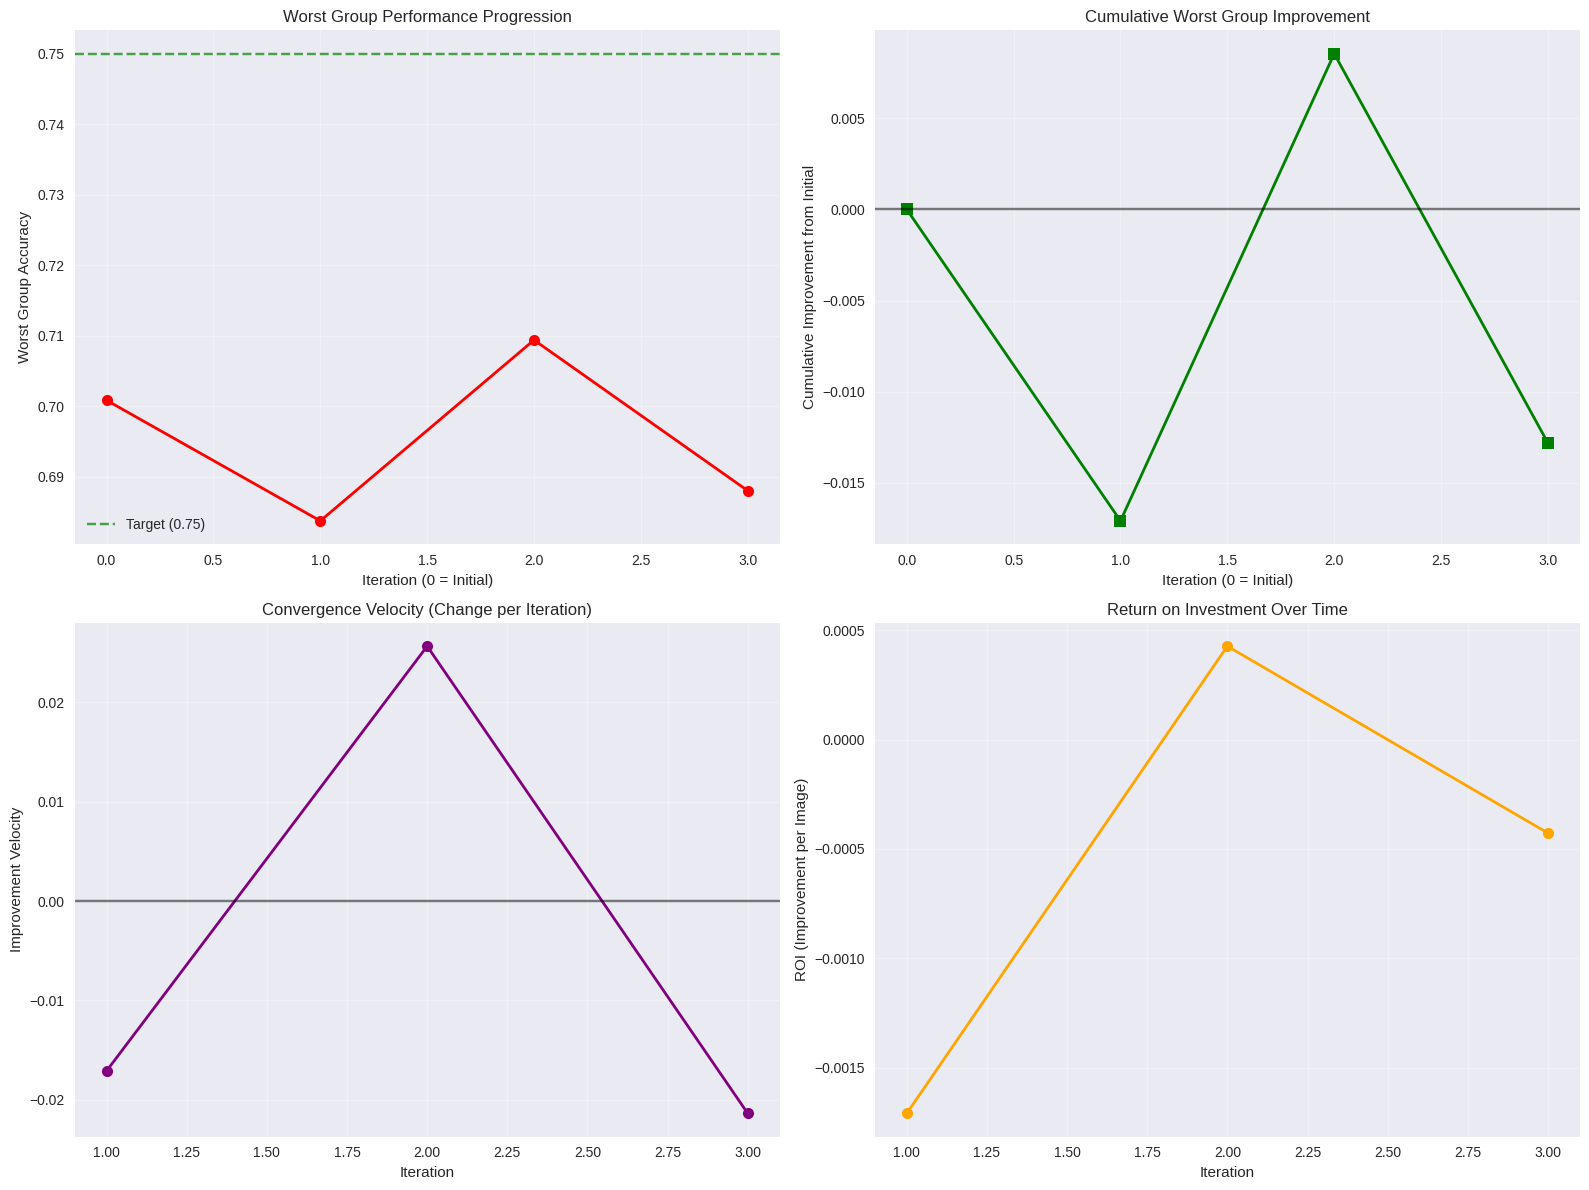

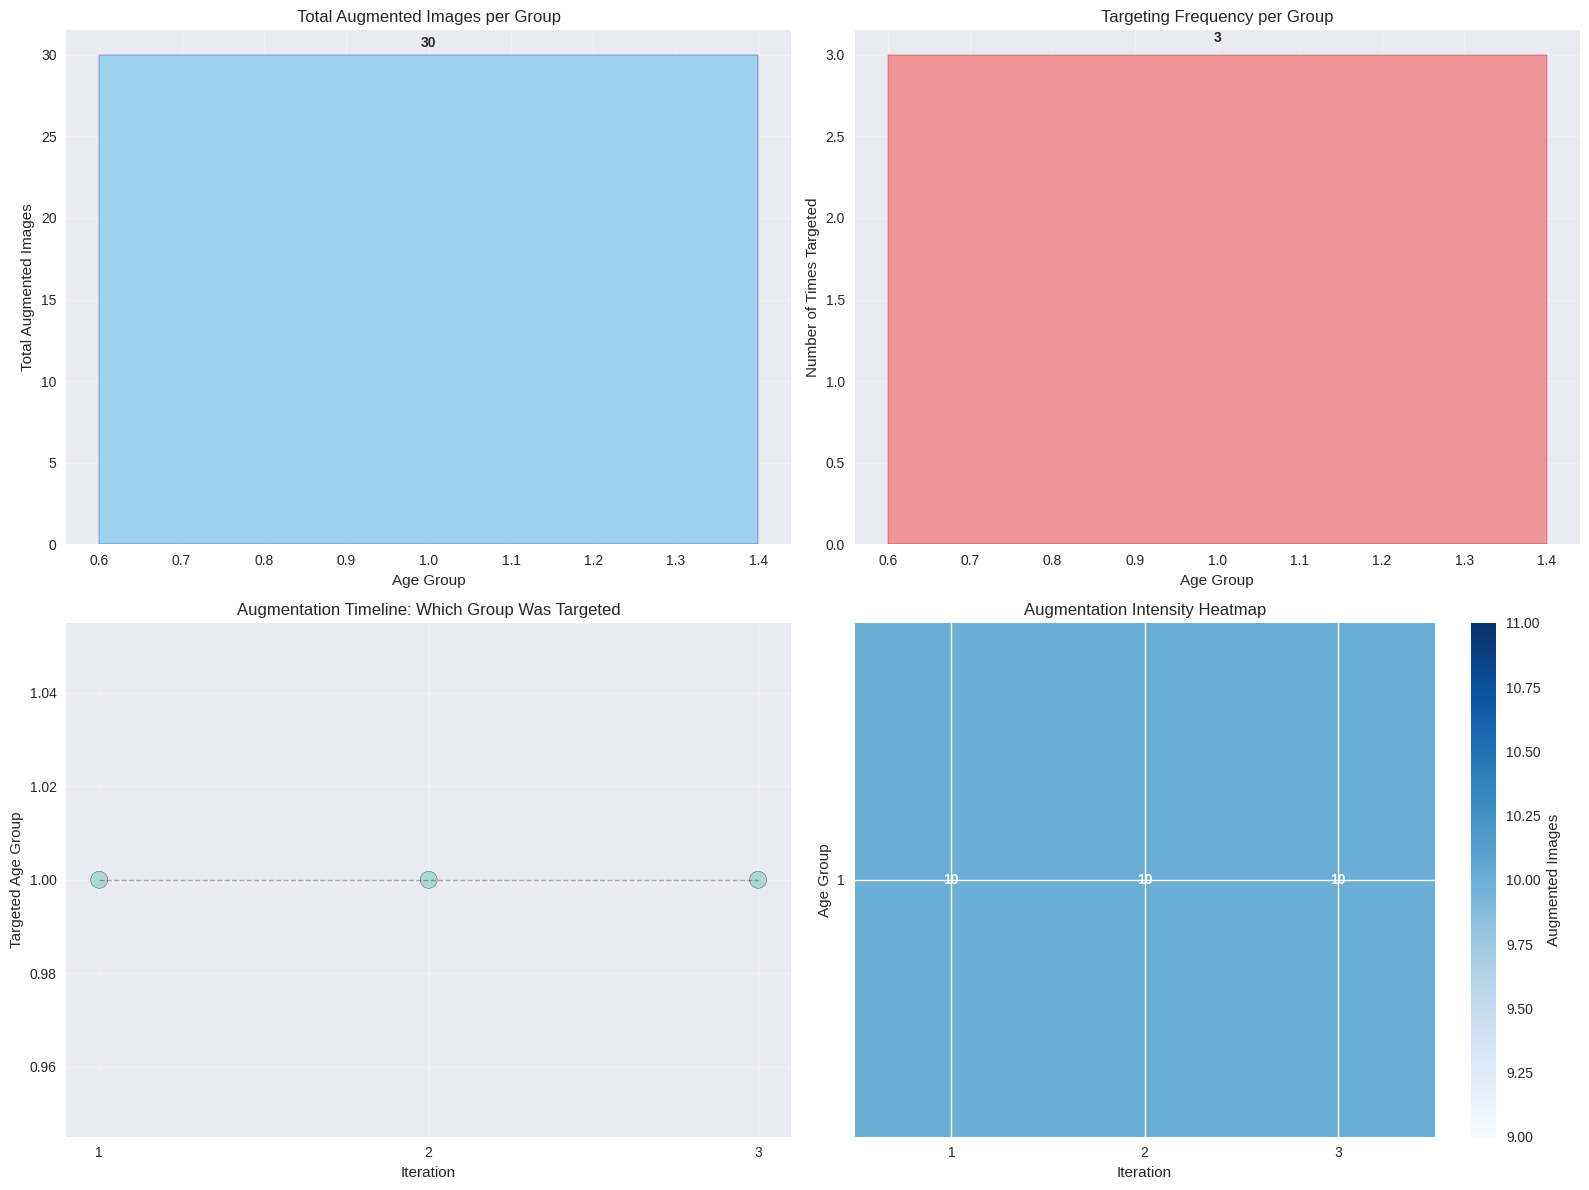

/tmp/ipykernel_908437/912632873.py:304: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box_plot = ax4.boxplot(group_improvements, labels=[f'Group {int(g)}' for g in groups], patch_artist=True)


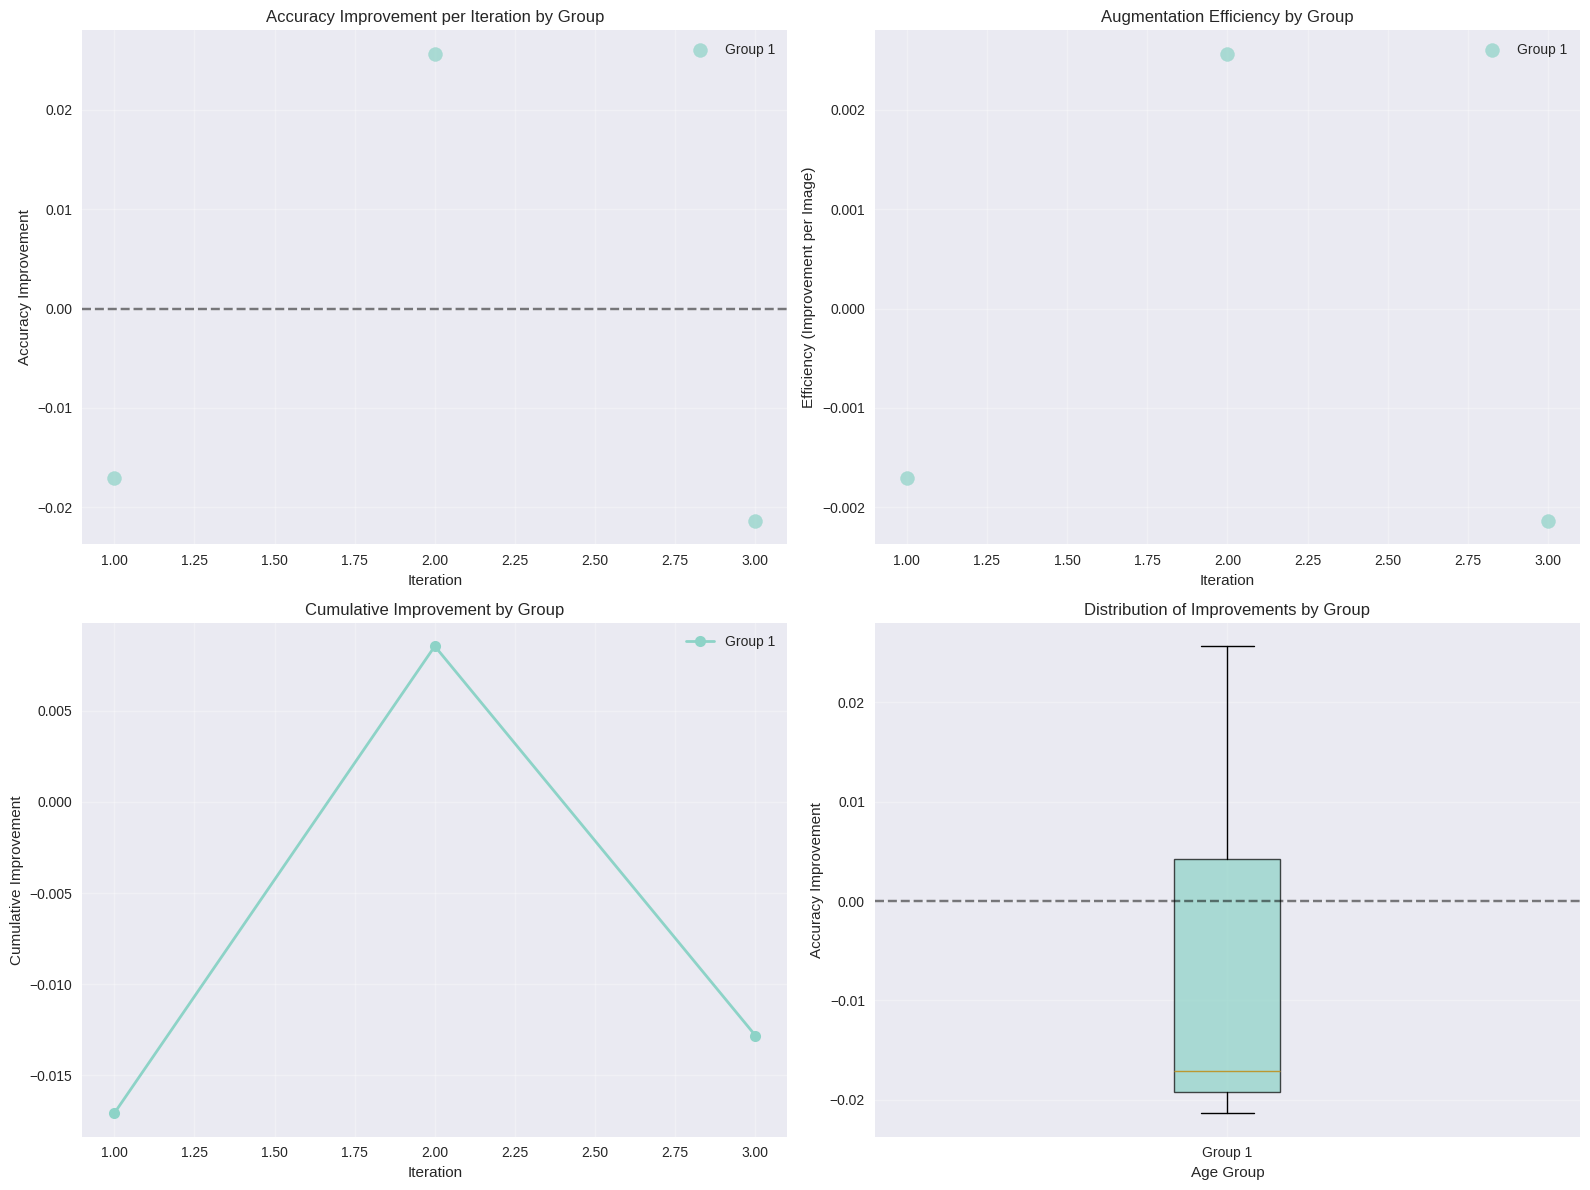

COMPREHENSIVE FAIRNESS AUGMENTATION ANALYSIS REPORT

📊 OVERALL STATISTICS:
Total Iterations: 3
Total Augmented Images: 30
Images per Iteration: 10

🏁 INITIAL STATE:
Initial Weighted Average Accuracy: 0.793
Initial Standard Deviation: 0.052
Initial Min Accuracy: 0.701
Initial Max Accuracy: 0.825
Initial Min-Max Gap: 0.125

🎯 FINAL STATE:
Final Weighted Average Accuracy: 0.800
Final Standard Deviation: 0.076
Final Min Accuracy: 0.688
Final Max Accuracy: 0.874
Final Min-Max Gap: 0.186

💰 PRICE OF FAIRNESS:
Price of Fairness (Accuracy Loss): -0.007
Fairness Improvement (Std Dev Reduction): -0.024
Gap Reduction: -0.061

📈 WORST GROUP PROGRESSION:
Initial Worst Group Accuracy: 0.701
Final Worst Group Accuracy: 0.688
Worst Group Improvement: -0.013 (-1.8%)

🔄 ITERATION ANALYSIS:
Iterations with Positive Improvement: 1/3
Average Improvement per Iteration: -0.004
Best Single Iteration Improvement: 0.026
Worst Single Iteration Change: -0.021

🎯 AUGMENTATION TARGETING ANALYSIS:
Number of Unique G

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle
import json
from collections import Counter

# Set style for better-looking plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Load the JSON data from results.json
with open('results/adience_human_5.json', 'r') as f:
    json_data = json.load(f)

# Create comprehensive dataset from your JSON
def parse_fairness_data(json_data):
    """Parse the fairness augmentation JSON data into pandas DataFrames"""

    # Parse initial performance data
    initial_performance = []
    for group_perf in json_data['init']['all_group_performances']:
        initial_performance.append({
            'age_group': group_perf['attributes']['age'],
            'accuracy': group_perf['accuracy'],
            'count': group_perf['count']
        })

    initial_df = pd.DataFrame(initial_performance)

    # Main iterations DataFrame
    iterations_df = []

    # Detailed performance tracking for all iterations
    performance_tracking = []

    # Augmentation tracking - NEW
    augmentation_tracking = []

    for iter_data in json_data['iterations']:
        iteration = iter_data['iteration']

        # Basic iteration info
        iterations_df.append({
            'iteration': iteration,
            'worst_group_before_age': iter_data['worst_group_before_aug']['attributes']['age'],
            'worst_accuracy_before': iter_data['worst_group_before_aug']['accuracy'],
            'worst_group_count': iter_data['worst_group_before_aug']['count'],
            'augmented_images': iter_data['augmented_images_generated'],
            'worst_group_after_age': iter_data['fairness_evaluation_after_aug']['worst_performing_group']['attributes']['age'],
            'worst_accuracy_after': iter_data['fairness_evaluation_after_aug']['worst_performing_group']['accuracy']
        })

        # Performance for all groups in this iteration
        for group_perf in iter_data['fairness_evaluation_after_aug']['all_group_performances']:
            performance_tracking.append({
                'iteration': iteration,
                'age_group': group_perf['attributes']['age'],
                'accuracy': group_perf['accuracy'],
                'count': group_perf['count']
            })

        # Augmentation tracking - NEW
        augmentation_tracking.append({
            'iteration': iteration,
            'targeted_group': iter_data['worst_group_before_aug']['attributes']['age'],
            'augmented_images': iter_data['augmented_images_generated']
        })

    return initial_df, pd.DataFrame(iterations_df), pd.DataFrame(performance_tracking), pd.DataFrame(augmentation_tracking)

# Parse the data and create DataFrames
initial_df, iterations_df, performance_df, augmentation_df = parse_fairness_data(json_data)

def calculate_price_of_fairness(initial_df, performance_df):
    """Calculate the price of fairness - how much overall performance is sacrificed for fairness"""

    # Get final iteration performance
    final_iteration = performance_df['iteration'].max()
    final_performance = performance_df[performance_df['iteration'] == final_iteration]

    # Calculate weighted average accuracy (initial vs final)
    initial_weighted_avg = (initial_df['accuracy'] * initial_df['count']).sum() / initial_df['count'].sum()
    final_weighted_avg = (final_performance['accuracy'] * final_performance['count']).sum() / final_performance['count'].sum()

    # Calculate fairness metrics
    initial_std = initial_df['accuracy'].std()
    final_std = final_performance['accuracy'].std()

    initial_min_max_gap = initial_df['accuracy'].max() - initial_df['accuracy'].min()
    final_min_max_gap = final_performance['accuracy'].max() - final_performance['accuracy'].min()

    price_of_fairness = initial_weighted_avg - final_weighted_avg
    fairness_improvement = initial_std - final_std
    gap_reduction = initial_min_max_gap - final_min_max_gap

    return {
        'price_of_fairness': price_of_fairness,
        'fairness_improvement_std': fairness_improvement,
        'gap_reduction': gap_reduction,
        'initial_weighted_avg': initial_weighted_avg,
        'final_weighted_avg': final_weighted_avg,
        'initial_std': initial_std,
        'final_std': final_std
    }

# NEW: Augmentation Analysis Functions
def analyze_augmentation_patterns():
    """Analyze augmentation patterns across iterations"""

    # Count total augmentations per group
    augmentation_counts = Counter()
    for _, row in augmentation_df.iterrows():
        augmentation_counts[row['targeted_group']] += row['augmented_images']

    # Count how many times each group was targeted
    targeting_counts = Counter(augmentation_df['targeted_group'])

    return augmentation_counts, targeting_counts

def plot_augmentation_analysis():
    """Plot comprehensive augmentation analysis"""
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

    augmentation_counts, targeting_counts = analyze_augmentation_patterns()

    # Plot 1: Total augmented images per group
    groups = list(augmentation_counts.keys())
    total_images = list(augmentation_counts.values())

    bars1 = ax1.bar(groups, total_images, alpha=0.8, color='skyblue', edgecolor='darkblue')
    ax1.set_xlabel('Age Group')
    ax1.set_ylabel('Total Augmented Images')
    ax1.set_title('Total Augmented Images per Group')
    ax1.grid(True, alpha=0.3)

    # Add value labels
    for bar, value in zip(bars1, total_images):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(total_images)*0.01,
                f'{value}', ha='center', va='bottom', fontweight='bold')

    # Plot 2: Number of times each group was targeted
    targeting_groups = list(targeting_counts.keys())
    targeting_times = list(targeting_counts.values())

    bars2 = ax2.bar(targeting_groups, targeting_times, alpha=0.8, color='lightcoral', edgecolor='darkred')
    ax2.set_xlabel('Age Group')
    ax2.set_ylabel('Number of Times Targeted')
    ax2.set_title('Targeting Frequency per Group')
    ax2.grid(True, alpha=0.3)

    # Add value labels
    for bar, value in zip(bars2, targeting_times):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(targeting_times)*0.02,
                f'{value}', ha='center', va='bottom', fontweight='bold')

    # Plot 3: Augmentation timeline - which group was targeted in each iteration
    iterations = augmentation_df['iteration'].tolist()
    targeted_groups = augmentation_df['targeted_group'].tolist()

    # Create a color map for groups
    unique_groups = sorted(set(targeted_groups))
    colors = plt.cm.Set3(np.linspace(0, 1, len(unique_groups)))
    color_map = {group: colors[i] for i, group in enumerate(unique_groups)}

    # Create scatter plot
    scatter_colors = [color_map[group] for group in targeted_groups]
    scatter = ax3.scatter(iterations, targeted_groups, c=scatter_colors, s=150, alpha=0.7, edgecolors='black')

    # Connect the dots
    ax3.plot(iterations, targeted_groups, 'k--', alpha=0.3, linewidth=1)

    ax3.set_xlabel('Iteration')
    ax3.set_ylabel('Targeted Age Group')
    ax3.set_title('Augmentation Timeline: Which Group Was Targeted')
    ax3.grid(True, alpha=0.3)
    ax3.set_xticks(iterations)

    # Plot 4: Heatmap of augmentation intensity
    # Create a matrix showing iterations vs groups
    all_groups = sorted(set(augmentation_df['targeted_group']))
    all_iterations = sorted(set(augmentation_df['iteration']))

    # Create matrix
    heatmap_data = np.zeros((len(all_groups), len(all_iterations)))

    for i, group in enumerate(all_groups):
        for j, iteration in enumerate(all_iterations):
            augmented = augmentation_df[
                (augmentation_df['targeted_group'] == group) &
                (augmentation_df['iteration'] == iteration)
            ]['augmented_images'].sum()
            heatmap_data[i, j] = augmented

    # Create heatmap
    im = ax4.imshow(heatmap_data, cmap='Blues', aspect='auto')
    ax4.set_xticks(range(len(all_iterations)))
    ax4.set_yticks(range(len(all_groups)))
    ax4.set_xticklabels(all_iterations)
    ax4.set_yticklabels(all_groups)
    ax4.set_xlabel('Iteration')
    ax4.set_ylabel('Age Group')
    ax4.set_title('Augmentation Intensity Heatmap')

    # Add text annotations
    for i in range(len(all_groups)):
        for j in range(len(all_iterations)):
            if heatmap_data[i, j] > 0:
                ax4.text(j, i, f'{int(heatmap_data[i, j])}', ha='center', va='center',
                        color='white' if heatmap_data[i, j] > heatmap_data.max()/2 else 'black',
                        fontweight='bold')

    # Add colorbar
    plt.colorbar(im, ax=ax4, label='Augmented Images')

    plt.tight_layout()
    plt.show()

def plot_augmentation_effectiveness():
    """Plot the effectiveness of augmentation for each group"""
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

    # Calculate effectiveness metrics
    effectiveness_data = []

    for _, row in augmentation_df.iterrows():
        iteration = row['iteration']
        targeted_group = row['targeted_group']

        # Get before and after performance for the targeted group
        before_perf = iterations_df[iterations_df['iteration'] == iteration]['worst_accuracy_before'].iloc[0]
        after_perf = performance_df[
            (performance_df['iteration'] == iteration) &
            (performance_df['age_group'] == targeted_group)
        ]['accuracy'].iloc[0]

        improvement = after_perf - before_perf
        images_used = row['augmented_images']
        efficiency = improvement / images_used if images_used > 0 else 0

        effectiveness_data.append({
            'iteration': iteration,
            'targeted_group': targeted_group,
            'before_accuracy': before_perf,
            'after_accuracy': after_perf,
            'improvement': improvement,
            'images_used': images_used,
            'efficiency': efficiency
        })

    effectiveness_df = pd.DataFrame(effectiveness_data)

    # Plot 1: Improvement per iteration by group
    groups = sorted(effectiveness_df['targeted_group'].unique())
    group_colors = plt.cm.Set3(np.linspace(0, 1, len(groups)))

    for i, group in enumerate(groups):
        group_data = effectiveness_df[effectiveness_df['targeted_group'] == group]
        ax1.scatter(group_data['iteration'], group_data['improvement'],
                   color=group_colors[i], label=f'Group {int(group)}', s=100, alpha=0.7)

    ax1.set_xlabel('Iteration')
    ax1.set_ylabel('Accuracy Improvement')
    ax1.set_title('Accuracy Improvement per Iteration by Group')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.axhline(y=0, color='black', linestyle='--', alpha=0.5)

    # Plot 2: Efficiency (improvement per image) by group
    for i, group in enumerate(groups):
        group_data = effectiveness_df[effectiveness_df['targeted_group'] == group]
        ax2.scatter(group_data['iteration'], group_data['efficiency'],
                   color=group_colors[i], label=f'Group {int(group)}', s=100, alpha=0.7)

    ax2.set_xlabel('Iteration')
    ax2.set_ylabel('Efficiency (Improvement per Image)')
    ax2.set_title('Augmentation Efficiency by Group')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # Plot 3: Cumulative improvement by group
    cumulative_improvement = {}
    for group in groups:
        group_data = effectiveness_df[effectiveness_df['targeted_group'] == group].sort_values('iteration')
        cumulative_improvement[group] = group_data['improvement'].cumsum().tolist()

    for i, group in enumerate(groups):
        group_data = effectiveness_df[effectiveness_df['targeted_group'] == group].sort_values('iteration')
        if len(group_data) > 0:
            ax3.plot(group_data['iteration'], cumulative_improvement[group],
                    'o-', color=group_colors[i], label=f'Group {int(group)}', linewidth=2, markersize=8)

    ax3.set_xlabel('Iteration')
    ax3.set_ylabel('Cumulative Improvement')
    ax3.set_title('Cumulative Improvement by Group')
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    # Plot 4: Box plot of improvement by group
    group_improvements = [effectiveness_df[effectiveness_df['targeted_group'] == group]['improvement'].tolist()
                         for group in groups]

    box_plot = ax4.boxplot(group_improvements, labels=[f'Group {int(g)}' for g in groups], patch_artist=True)

    # Color the boxes
    for patch, color in zip(box_plot['boxes'], group_colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)

    ax4.set_xlabel('Age Group')
    ax4.set_ylabel('Accuracy Improvement')
    ax4.set_title('Distribution of Improvements by Group')
    ax4.grid(True, alpha=0.3)
    ax4.axhline(y=0, color='black', linestyle='--', alpha=0.5)

    plt.tight_layout()
    plt.show()

# 1. PERFORMANCE COMPARISON WITH INITIAL STATE
def plot_performance_comparison():
    """Compare performance across all groups: initial vs final"""
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

    # Get final performance
    final_iteration = performance_df['iteration'].max()
    final_performance = performance_df[performance_df['iteration'] == final_iteration]

    # Merge initial and final for comparison
    comparison_df = initial_df.merge(final_performance, on='age_group', suffixes=('_initial', '_final'))

    # Plot 1: Bar comparison
    x = np.arange(len(comparison_df))
    width = 0.35

    bars1 = ax1.bar(x - width/2, comparison_df['accuracy_initial'], width,
                   label='Initial', alpha=0.8, color='lightblue')
    bars2 = ax1.bar(x + width/2, comparison_df['accuracy_final'], width,
                   label='Final', alpha=0.8, color='darkblue')

    ax1.set_xlabel('Age Group')
    ax1.set_ylabel('Accuracy')
    ax1.set_title('Initial vs Final Performance by Age Group')
    ax1.set_xticks(x)
    ax1.set_xticklabels(comparison_df['age_group'])
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Add value labels
    for bar1, bar2 in zip(bars1, bars2):
        ax1.text(bar1.get_x() + bar1.get_width()/2, bar1.get_height() + 0.01,
                f'{bar1.get_height():.3f}', ha='center', va='bottom', fontsize=9)
        ax1.text(bar2.get_x() + bar2.get_width()/2, bar2.get_height() + 0.01,
                f'{bar2.get_height():.3f}', ha='center', va='bottom', fontsize=9)

    # Plot 2: Change in accuracy
    accuracy_change = comparison_df['accuracy_final'] - comparison_df['accuracy_initial']
    colors = ['green' if x > 0 else 'red' if x < 0 else 'gray' for x in accuracy_change]
    bars = ax2.bar(comparison_df['age_group'], accuracy_change, color=colors, alpha=0.7)
    ax2.axhline(y=0, color='black', linestyle='-', alpha=0.5)
    ax2.set_xlabel('Age Group')
    ax2.set_ylabel('Accuracy Change')
    ax2.set_title('Accuracy Change: Final - Initial')
    ax2.grid(True, alpha=0.3)

    # Add value labels
    for bar, value in zip(bars, accuracy_change):
        ax2.text(bar.get_x() + bar.get_width()/2,
                bar.get_height() + (0.005 if value > 0 else -0.015),
                f'{value:.3f}', ha='center', va='bottom' if value > 0 else 'top',
                fontsize=9, fontweight='bold')

    # Plot 3: Fairness metrics over time
    fairness_metrics = []
    for iteration in range(1, iterations_df['iteration'].max() + 1):
        iter_performance = performance_df[performance_df['iteration'] == iteration]
        std_dev = iter_performance['accuracy'].std()
        min_max_gap = iter_performance['accuracy'].max() - iter_performance['accuracy'].min()
        fairness_metrics.append({
            'iteration': iteration,
            'std_dev': std_dev,
            'min_max_gap': min_max_gap
        })

    # Add initial values
    initial_std = initial_df['accuracy'].std()
    initial_gap = initial_df['accuracy'].max() - initial_df['accuracy'].min()

    fairness_df = pd.DataFrame(fairness_metrics)
    iterations_plot = [0] + list(fairness_df['iteration'])
    std_plot = [initial_std] + list(fairness_df['std_dev'])
    gap_plot = [initial_gap] + list(fairness_df['min_max_gap'])

    ax3.plot(iterations_plot, std_plot, 'o-', label='Standard Deviation', linewidth=2, markersize=8)
    ax3.plot(iterations_plot, gap_plot, 's-', label='Min-Max Gap', linewidth=2, markersize=8)
    ax3.set_xlabel('Iteration (0 = Initial)')
    ax3.set_ylabel('Fairness Metric')
    ax3.set_title('Fairness Metrics Over Time')
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    # Plot 4: Group performance evolution
    all_groups = sorted(initial_df['age_group'].unique())
    colors = plt.cm.Set3(np.linspace(0, 1, len(all_groups)))

    for i, group in enumerate(all_groups):
        group_evolution = []
        iterations_list = []

        # Initial performance
        initial_acc = initial_df[initial_df['age_group'] == group]['accuracy'].iloc[0]
        group_evolution.append(initial_acc)
        iterations_list.append(0)

        # Performance over iterations
        for iteration in range(1, iterations_df['iteration'].max() + 1):
            iter_perf = performance_df[(performance_df['iteration'] == iteration) &
                                     (performance_df['age_group'] == group)]
            if not iter_perf.empty:
                group_evolution.append(iter_perf['accuracy'].iloc[0])
                iterations_list.append(iteration)

        ax4.plot(iterations_list, group_evolution, 'o-', label=f'Age Group {group}',
                color=colors[i], linewidth=2, markersize=6)

    ax4.set_xlabel('Iteration (0 = Initial)')
    ax4.set_ylabel('Accuracy')
    ax4.set_title('Group Performance Evolution')
    ax4.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax4.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# 2. PRICE OF FAIRNESS ANALYSIS
def plot_price_of_fairness():
    """Analyze the price of fairness in detail"""
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

    # Calculate metrics for each iteration
    iteration_metrics = []

    # Initial state
    initial_weighted_avg = (initial_df['accuracy'] * initial_df['count']).sum() / initial_df['count'].sum()
    initial_std = initial_df['accuracy'].std()
    initial_min = initial_df['accuracy'].min()

    iteration_metrics.append({
        'iteration': 0,
        'weighted_avg': initial_weighted_avg,
        'std_dev': initial_std,
        'min_accuracy': initial_min,
        'price_of_fairness': 0,
        'fairness_gain': 0
    })

    for iteration in range(1, iterations_df['iteration'].max() + 1):
        iter_performance = performance_df[performance_df['iteration'] == iteration]
        weighted_avg = (iter_performance['accuracy'] * iter_performance['count']).sum() / iter_performance['count'].sum()
        std_dev = iter_performance['accuracy'].std()
        min_acc = iter_performance['accuracy'].min()

        price_of_fairness = initial_weighted_avg - weighted_avg
        fairness_gain = initial_std - std_dev

        iteration_metrics.append({
            'iteration': iteration,
            'weighted_avg': weighted_avg,
            'std_dev': std_dev,
            'min_accuracy': min_acc,
            'price_of_fairness': price_of_fairness,
            'fairness_gain': fairness_gain
        })

    metrics_df = pd.DataFrame(iteration_metrics)

    # Plot 1: Price of Fairness over time
    ax1.plot(metrics_df['iteration'], metrics_df['price_of_fairness'], 'ro-',
             linewidth=2, markersize=8, label='Price of Fairness')
    ax1.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    ax1.set_xlabel('Iteration (0 = Initial)')
    ax1.set_ylabel('Price of Fairness (Accuracy Loss)')
    ax1.set_title('Price of Fairness Over Time')
    ax1.grid(True, alpha=0.3)
    ax1.legend()

    # Plot 2: Fairness gain vs price
    ax2.scatter(metrics_df['price_of_fairness'], metrics_df['fairness_gain'],
                c=metrics_df['iteration'], cmap='viridis', s=100, alpha=0.7)
    ax2.set_xlabel('Price of Fairness (Accuracy Loss)')
    ax2.set_ylabel('Fairness Gain (Std Dev Reduction)')
    ax2.set_title('Fairness Gain vs Price Trade-off')
    ax2.grid(True, alpha=0.3)

    # Add colorbar
    cbar = plt.colorbar(ax2.collections[0], ax=ax2)
    cbar.set_label('Iteration')

    # Plot 3: Efficiency ratio
    efficiency_ratio = metrics_df['fairness_gain'] / (metrics_df['price_of_fairness'] + 1e-10)  # Avoid division by zero
    ax3.plot(metrics_df['iteration'], efficiency_ratio, 'go-', linewidth=2, markersize=8)
    ax3.set_xlabel('Iteration (0 = Initial)')
    ax3.set_ylabel('Efficiency Ratio (Fairness Gain / Price)')
    ax3.set_title('Fairness Efficiency Over Time')
    ax3.grid(True, alpha=0.3)

    # Plot 4: Triple metric evolution
    ax4_twin1 = ax4.twinx()
    ax4_twin2 = ax4.twinx()
    ax4_twin2.spines['right'].set_position(('outward', 60))

    p1 = ax4.plot(metrics_df['iteration'], metrics_df['weighted_avg'], 'b-',
                  linewidth=2, label='Weighted Avg Accuracy')
    p2 = ax4_twin1.plot(metrics_df['iteration'], metrics_df['std_dev'], 'r-',
                        linewidth=2, label='Std Dev')
    p3 = ax4_twin2.plot(metrics_df['iteration'], metrics_df['min_accuracy'], 'g-',
                        linewidth=2, label='Min Accuracy')

    ax4.set_xlabel('Iteration (0 = Initial)')
    ax4.set_ylabel('Weighted Avg Accuracy', color='b')
    ax4_twin1.set_ylabel('Standard Deviation', color='r')
    ax4_twin2.set_ylabel('Min Accuracy', color='g')
    ax4.set_title('Triple Metric Evolution')

    # Combine legends
    lines = p1 + p2 + p3
    labels = [l.get_label() for l in lines]
    ax4.legend(lines, labels, loc='upper left')

    plt.tight_layout()
    plt.show()

# 3. ENHANCED CONVERGENCE ANALYSIS
def plot_enhanced_convergence():
    """Enhanced convergence analysis with initial state"""
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

    # Plot 1: Worst group progression including initial
    initial_worst = initial_df['accuracy'].min()
    worst_progression = [initial_worst] + list(iterations_df['worst_accuracy_after'])
    iterations_plot = [0] + list(iterations_df['iteration'])

    ax1.plot(iterations_plot, worst_progression, 'o-', linewidth=2, markersize=8, color='red')
    ax1.axhline(y=0.75, color='green', linestyle='--', alpha=0.7, label='Target (0.75)')
    ax1.set_xlabel('Iteration (0 = Initial)')
    ax1.set_ylabel('Worst Group Accuracy')
    ax1.set_title('Worst Group Performance Progression')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Plot 2: Cumulative improvement from initial
    cumulative_improvement = np.array(worst_progression) - initial_worst
    ax2.plot(iterations_plot, cumulative_improvement, 's-', linewidth=2, markersize=8, color='green')
    ax2.axhline(y=0, color='black', linestyle='-', alpha=0.5)
    ax2.set_xlabel('Iteration (0 = Initial)')
    ax2.set_ylabel('Cumulative Improvement from Initial')
    ax2.set_title('Cumulative Worst Group Improvement')
    ax2.grid(True, alpha=0.3)

    # Plot 3: Convergence velocity
    velocity = np.diff(worst_progression)
    ax3.plot(range(1, len(velocity) + 1), velocity, 'o-', linewidth=2, markersize=8, color='purple')
    ax3.axhline(y=0, color='black', linestyle='-', alpha=0.5)
    ax3.set_xlabel('Iteration')
    ax3.set_ylabel('Improvement Velocity')
    ax3.set_title('Convergence Velocity (Change per Iteration)')
    ax3.grid(True, alpha=0.3)

    # Plot 4: ROI analysis including initial cost
    cumulative_images = [0] + list(iterations_df['augmented_images'].cumsum())
    cumulative_improvement_from_initial = cumulative_improvement

    # Calculate ROI
    roi_values = []
    for i in range(1, len(cumulative_images)):
        if cumulative_images[i] > 0:
            roi = cumulative_improvement_from_initial[i] / cumulative_images[i]
            roi_values.append(roi)
        else:
            roi_values.append(0)

    ax4.plot(range(1, len(roi_values) + 1), roi_values, 'o-', linewidth=2, markersize=8, color='orange')
    ax4.set_xlabel('Iteration')
    ax4.set_ylabel('ROI (Improvement per Image)')
    ax4.set_title('Return on Investment Over Time')
    ax4.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# 4. COMPREHENSIVE STATISTICS
def print_comprehensive_statistics():
    """Print comprehensive statistics including price of fairness and augmentation analysis"""
    print("="*70)
    print("COMPREHENSIVE FAIRNESS AUGMENTATION ANALYSIS REPORT")
    print("="*70)

    # Calculate price of fairness
    pof_metrics = calculate_price_of_fairness(initial_df, performance_df)

    # Calculate augmentation statistics
    augmentation_counts, targeting_counts = analyze_augmentation_patterns()

    print(f"\n📊 OVERALL STATISTICS:")
    print(f"Total Iterations: {len(iterations_df)}")
    print(f"Total Augmented Images: {iterations_df['augmented_images'].sum()}")
    print(f"Images per Iteration: {iterations_df['augmented_images'].iloc[0]}")

    print(f"\n🏁 INITIAL STATE:")
    print(f"Initial Weighted Average Accuracy: {pof_metrics['initial_weighted_avg']:.3f}")
    print(f"Initial Standard Deviation: {pof_metrics['initial_std']:.3f}")
    print(f"Initial Min Accuracy: {initial_df['accuracy'].min():.3f}")
    print(f"Initial Max Accuracy: {initial_df['accuracy'].max():.3f}")
    print(f"Initial Min-Max Gap: {initial_df['accuracy'].max() - initial_df['accuracy'].min():.3f}")

    print(f"\n🎯 FINAL STATE:")
    final_performance = performance_df[performance_df['iteration'] == performance_df['iteration'].max()]
    print(f"Final Weighted Average Accuracy: {pof_metrics['final_weighted_avg']:.3f}")
    print(f"Final Standard Deviation: {pof_metrics['final_std']:.3f}")
    print(f"Final Min Accuracy: {final_performance['accuracy'].min():.3f}")
    print(f"Final Max Accuracy: {final_performance['accuracy'].max():.3f}")
    print(f"Final Min-Max Gap: {final_performance['accuracy'].max() - final_performance['accuracy'].min():.3f}")

    print(f"\n💰 PRICE OF FAIRNESS:")
    print(f"Price of Fairness (Accuracy Loss): {pof_metrics['price_of_fairness']:.3f}")
    print(f"Fairness Improvement (Std Dev Reduction): {pof_metrics['fairness_improvement_std']:.3f}")
    print(f"Gap Reduction: {pof_metrics['gap_reduction']:.3f}")

    if pof_metrics['price_of_fairness'] > 0:
        print(f"Trade-off Ratio: {pof_metrics['fairness_improvement_std'] / pof_metrics['price_of_fairness']:.3f} fairness units per accuracy unit")

    print(f"\n📈 WORST GROUP PROGRESSION:")
    initial_worst = initial_df['accuracy'].min()
    final_worst = final_performance['accuracy'].min()
    worst_improvement = final_worst - initial_worst
    print(f"Initial Worst Group Accuracy: {initial_worst:.3f}")
    print(f"Final Worst Group Accuracy: {final_worst:.3f}")
    print(f"Worst Group Improvement: {worst_improvement:.3f} ({worst_improvement/initial_worst*100:.1f}%)")

    print(f"\n🔄 ITERATION ANALYSIS:")
    improvements = iterations_df['worst_accuracy_after'] - iterations_df['worst_accuracy_before']
    positive_improvements = sum(1 for x in improvements if x > 0)
    print(f"Iterations with Positive Improvement: {positive_improvements}/{len(iterations_df)}")
    print(f"Average Improvement per Iteration: {improvements.mean():.3f}")
    print(f"Best Single Iteration Improvement: {improvements.max():.3f}")
    print(f"Worst Single Iteration Change: {improvements.min():.3f}")

    print(f"\n🎯 AUGMENTATION TARGETING ANALYSIS:")
    print(f"Number of Unique Groups Targeted: {len(targeting_counts)}")
    print(f"Most Targeted Group: {max(targeting_counts, key=targeting_counts.get)} (targeted {targeting_counts[max(targeting_counts, key=targeting_counts.get)]} times)")
    print(f"Least Targeted Group: {min(targeting_counts, key=targeting_counts.get)} (targeted {targeting_counts[min(targeting_counts, key=targeting_counts.get)]} times)")

    print(f"\n📊 GROUP-WISE TARGETING BREAKDOWN:")
    print(f"{'Group':<6} {'Times Targeted':<15} {'Total Images':<15} {'Avg Images/Target':<18}")
    print("-" * 65)
    for group in sorted(targeting_counts.keys()):
        times_targeted = targeting_counts[group]
        total_images = augmentation_counts[group]
        avg_images = total_images / times_targeted if times_targeted > 0 else 0
        print(f"{int(group):<6} {times_targeted:<15} {total_images:<15} {avg_images:<18.1f}")

    print(f"\n📊 GROUP-WISE PERFORMANCE ANALYSIS:")
    comparison_df = initial_df.merge(final_performance, on='age_group', suffixes=('_initial', '_final'))
    print(f"{'Group':<6} {'Initial':<8} {'Final':<8} {'Change':<8} {'% Change':<10} {'Targeted':<10}")
    print("-" * 65)
    for _, row in comparison_df.iterrows():
        change = row['accuracy_final'] - row['accuracy_initial']
        pct_change = (change / row['accuracy_initial']) * 100
        times_targeted = targeting_counts.get(row['age_group'], 0)
        print(f"{int(row['age_group']):<6} {row['accuracy_initial']:<8.3f} {row['accuracy_final']:<8.3f} {change:<8.3f} {pct_change:<10.1f}% {times_targeted:<10}")

    print(f"\n⚡ EFFICIENCY METRICS:")
    total_images = iterations_df['augmented_images'].sum()
    print(f"Images per Unit Worst Group Improvement: {total_images / worst_improvement:.0f}")
    print(f"Images per Unit Fairness Improvement: {total_images / pof_metrics['fairness_improvement_std']:.0f}")

    # Calculate targeting efficiency
    print(f"\n🎯 TARGETING EFFICIENCY:")
    for group in sorted(targeting_counts.keys()):
        group_initial = initial_df[initial_df['age_group'] == group]['accuracy'].iloc[0]
        group_final = final_performance[final_performance['age_group'] == group]['accuracy'].iloc[0]
        group_improvement = group_final - group_initial
        group_images = augmentation_counts[group]
        efficiency = group_improvement / group_images if group_images > 0 else 0
        print(f"Group {int(group)}: {efficiency:.6f} accuracy improvement per image")

    # Convergence analysis
    print(f"\n🔍 CONVERGENCE ANALYSIS:")
    if len(iterations_df) >= 3:
        last_3_changes = abs(iterations_df['worst_accuracy_after'].diff().tail(3))
        converged = all(change < 0.01 for change in last_3_changes if not pd.isna(change))
        print(f"Converged (< 1% change in last 3 iterations): {'Yes' if converged else 'No'}")

    # Success metrics
    print(f"\n🎯 SUCCESS METRICS:")
    target_accuracy = 0.75
    achieved_target = final_worst >= target_accuracy
    print(f"Target Accuracy (0.75) Achieved: {'Yes' if achieved_target else 'No'}")

    if not achieved_target:
        remaining_gap = target_accuracy - final_worst
        print(f"Remaining Gap to Target: {remaining_gap:.3f}")

    print(f"\n🔄 AUGMENTATION SEQUENCE:")
    print("Iteration -> Targeted Group -> Images Added -> Accuracy Before -> Accuracy After")
    print("-" * 80)
    for _, row in augmentation_df.iterrows():
        iter_data = iterations_df[iterations_df['iteration'] == row['iteration']].iloc[0]
        print(f"{row['iteration']:<9} -> {int(row['targeted_group']):<14} -> {row['augmented_images']:<12} -> {iter_data['worst_accuracy_before']:<15.3f} -> {iter_data['worst_accuracy_after']:<15.3f}")

# Run all analyses
if __name__ == "__main__":
    print("Running Enhanced Fairness Augmentation Analysis...")

    # Generate all plots
    plot_performance_comparison()
    plot_price_of_fairness()
    plot_enhanced_convergence()

    # NEW: Generate augmentation analysis plots
    plot_augmentation_analysis()
    plot_augmentation_effectiveness()

    # Print comprehensive statistics
    print_comprehensive_statistics()

    print("\n" + "="*70)
    print("ENHANCED ANALYSIS COMPLETE")
    print("="*70)